## Synthetic data set 2 : generation and analysis

**Date** : 2021-10-05<br>
**Author** : Alma Andersson<br>
**Description** : This notebook outlines the generation and analysis of Synthetic data set 2.

Load necessary libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys
import os.path as osp

import eggplant as eg


specify paths

In [31]:
SAVE_MODE = True
RES_DIR ="../../res/analysis/synthetic-2"

set font style

In [2]:
import matplotlib
matplotlib.rc('font', serif='Calibri')

set random seed

In [3]:
np.random.seed(9)

### Synthetic data generation

Generate synthetic spatial data using a Gaussian Random walk

In [4]:
img_size = 32
img = np.zeros((img_size,img_size))

Define helper function for Gaussian Random Walk

In [5]:
def take_step(xy):
    x = np.random.choice([-1,0,1])
    y = np.random.choice([-1,0,1])
    for k,s in enumerate([x,y]):
        if xy[k] + s < img_size and xy[k] + s >= 0:
            xy[k] = xy[k] + s
    return xy

Execute Gaussian Random walk

In [6]:
n_steps = int(1e4)
pos = np.random.uniform(0,img_size,size=2).astype(int)
img[pos[0],pos[1]] = 1
for step in range(n_steps):
    pos = take_step(pos)
    img[pos[0],pos[1]] += 1
    

Inspect resulting spatial expression profile (image format)

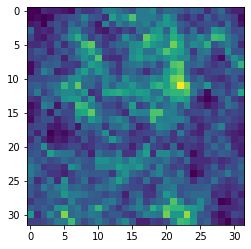

In [7]:
im = plt.imshow(img)
plt.colorbar
plt.show()

Convert image data to grid format, this is what we will be referring to as the *ground truth* data.

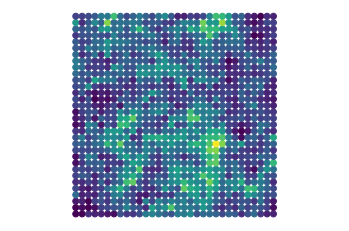

In [8]:
xx = np.arange(-img_size/2,img_size/2)
xx,yy = np.meshgrid(xx,xx)
crd = np.hstack((xx.flatten()[:,np.newaxis],
                 yy.flatten()[:,np.newaxis]))
vals = img.flatten()
plt.scatter(crd[:,0],crd[:,1],c = vals)
plt.axis("equal")
plt.axis("off")
plt.show()

Add landmarks using *Poisson Disc Sampling*

In [9]:
from scipy.spatial.distance import cdist
n_max_lmks = 40
n_lmks = np.linspace(3,n_max_lmks-1,10).astype(int)
sampler = eg.fun.PoissonDiscSampler(crd,min_dist = 3.9,seed=1)
lmk = sampler.sample(n_max_lmks)
lmk_idx = np.argmin(cdist(crd,lmk),axis=0)
lmk = crd[lmk_idx,:]

Visualize landmarks in spatial domain together with expression data

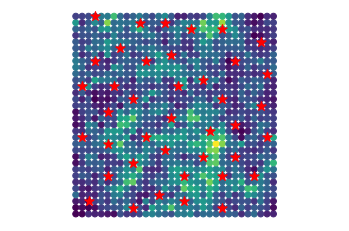

In [10]:
xx = np.arange(-img_size/2,img_size/2)
xx,yy = np.meshgrid(xx,xx)
crd = np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))
vals = img.flatten()
plt.scatter(crd[:,0],crd[:,1],c = vals)
plt.scatter(lmk[:,0],lmk[:,1],c = "red", marker  = "*", s = 100)
plt.axis("equal")
plt.axis("off")
plt.show()

Apply distortion field to the data

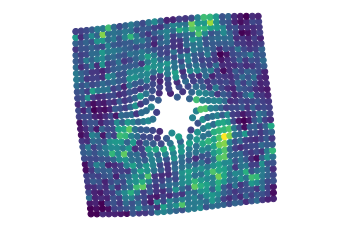

In [11]:
h = 2
x = np.linspace(-h,h,32)
y = np.linspace(-h,h,32)
x,y = np.meshgrid(x,y)

u = (-y + x)/np.sqrt(x**2 + y**2) * 2
v = (x + y)/np.sqrt(x**2 + y**2) * 2


new_xx = xx.flatten() + u.flatten()
new_yy = yy.flatten() + v.flatten()

new_crd = np.hstack((new_xx[:,np.newaxis],new_yy[:,np.newaxis]))
new_lmk = new_crd[lmk_idx,:]
plt.scatter(new_crd[:,0],new_crd[:,1],c  = vals)
plt.axis("equal")
plt.axis("off")
plt.show()

Create distorted version of the data by interpolating values on a grid.

In [12]:
from scipy.interpolate import griddata
new_vals = griddata(new_crd,vals,(xx,yy),method = "nearest")
new_vals = new_vals.flatten()

Create visualization of the whole synthetic data generation process

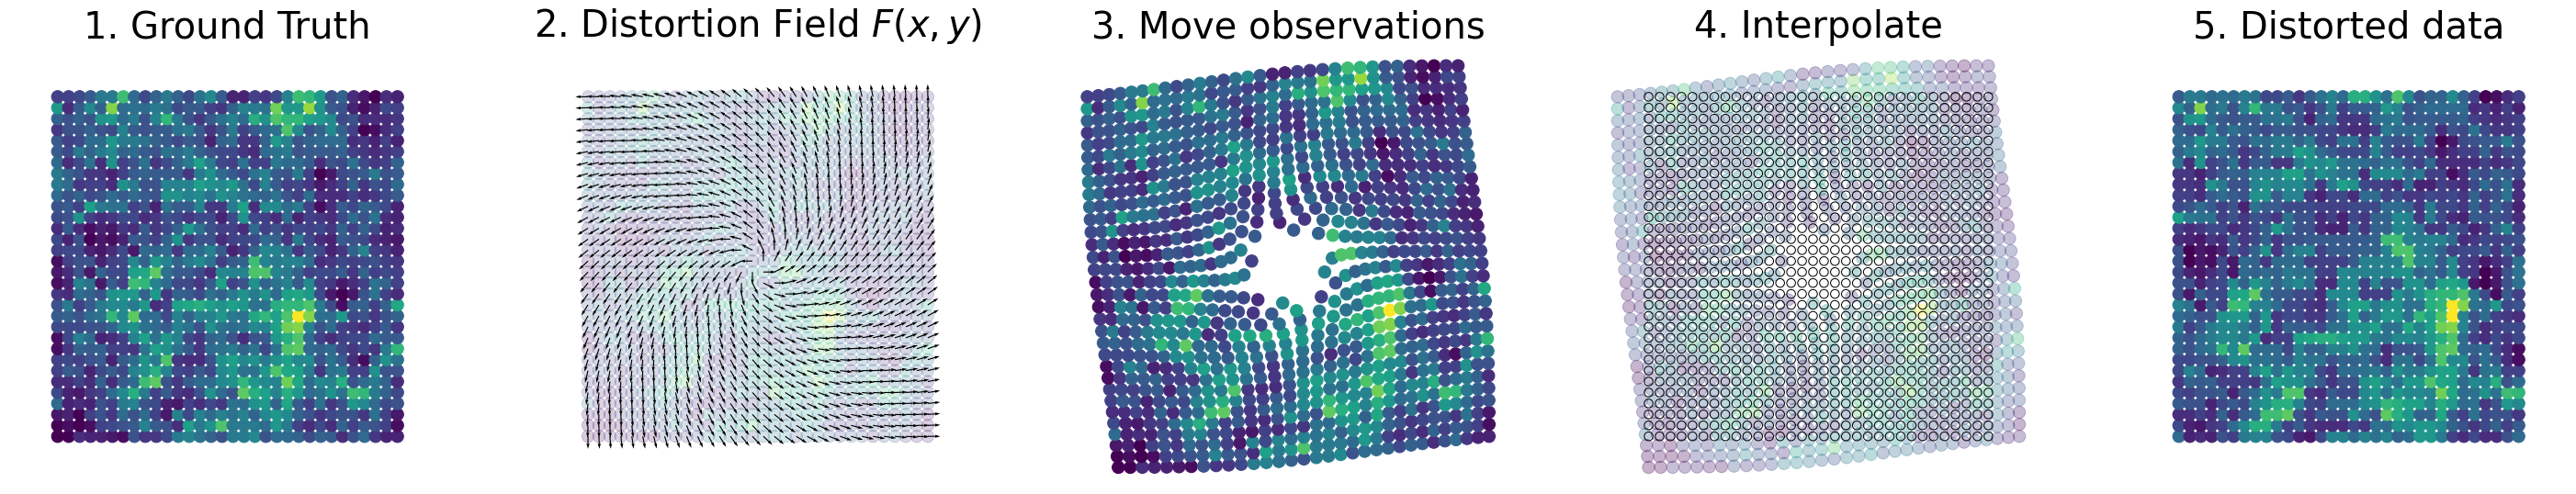

In [35]:
fz = 40
marker_size  = 180
fig,ax = plt.subplots(1,5,sharex=True,sharey=True,figsize = (50,10))

ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size)
ax[1].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size,alpha = 0.2)
ax[1].quiver(xx,yy,u,v,scale =100)
ax[2].scatter(new_crd[:,0],new_crd[:,1],c = vals,s=marker_size)
ax[3].scatter(new_crd[:,0],new_crd[:,1],c = vals,s=marker_size,alpha=0.3)
ax[3].scatter(crd[:,0],crd[:,1],s=marker_size / 2,facecolor = "none",edgecolor = "black")
ax[4].scatter(crd[:,0],crd[:,1],c = new_vals,s=marker_size)

ax[0].set_title("1. Ground Truth",fontsize=fz)
ax[1].set_title(r"2. Distortion Field $F(x,y)$",fontsize=fz)
ax[2].set_title("3. Move observations",fontsize=fz)
ax[3].set_title("4. Interpolate",fontsize=fz)
ax[4].set_title("5. Distorted data",fontsize=fz)

for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")

if SAVE_MODE: fig.savefig(osp.join(RES_DIR,"fig-2-a.png"),bbox_inches = "tight")
plt.show()

Compare ground truth data with the distorted data

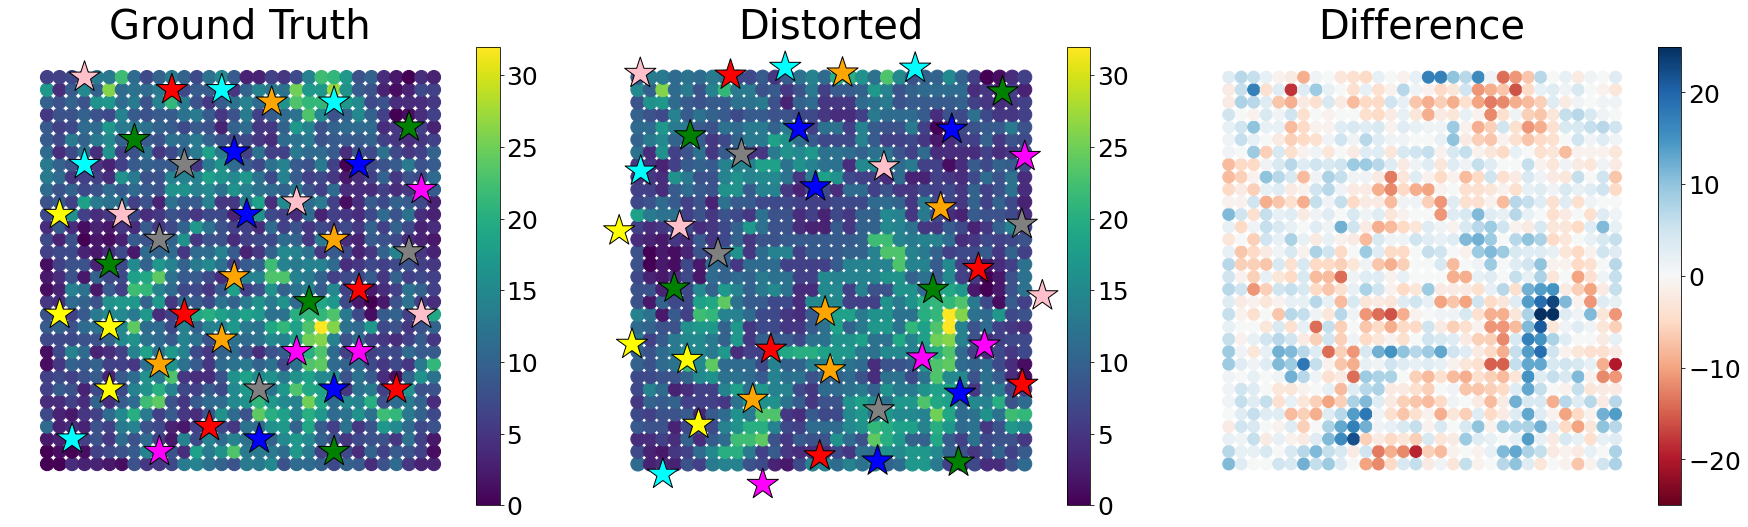

In [34]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

color_mapper = eg.pl.ColorMapper(eg.constants.LANDMARK_CMAP)
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize = (30,10))

scs = [None] * 3

scs[0] = ax[0].scatter(crd[:,0],crd[:,1],c = vals,s=marker_size)
ax[0].set_title("Ground Truth",fontsize = fz)
ax[0].scatter(lmk[:,0],
              lmk[:,1],
              c = color_mapper(lmk),
              s = marker_size * 6,
              marker = "*",
              edgecolor ="black",
              )

scs[1] = ax[1].scatter(crd[:,0],crd[:,1],c = new_vals,s=200)
ax[1].scatter(new_lmk[:,0],
              new_lmk[:,1],
              c =color_mapper(new_lmk),
              s = marker_size * 6,
              marker = "*",
              edgecolor ="black",
             )

ax[1].set_title("Distorted",fontsize = fz)

diff = new_vals - vals
vmax = max(abs(diff))
scs[2] = ax[2].scatter(crd[:,0],
                    crd[:,1],
                    c = new_vals - vals,
                    s=marker_size * 0.8,
                    cmap = plt.cm.RdBu,
                    vmin = -vmax,
                    vmax = vmax,
                    )

for k in range(len(scs)):
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scs[k], cax=cax)
    cbar.ax.tick_params(labelsize = 25)

ax[2].set_title("Difference",fontsize = fz)


for aa in ax:
    aa.set_aspect("equal")
    aa.axis("off")
    
if SAVE_MODE: plt.savefig(osp.join(RES_DIR,"fig-2-b.png"),bbox_inches = "tight")
plt.show()

### Analysis of synthetic data

build `anndata`object for analysis

In [16]:
X = np.hstack((vals[:,np.newaxis],new_vals[:,np.newaxis]))
var = pd.DataFrame(["original","distorted"],
                   index = ["original","distorted"],
                   columns = ["values"],
                  )
obs_index = [f"Location_{k}" for k in range(vals.shape[0])]
obs = pd.DataFrame(obs_index,
                   index = obs_index,
                   columns = ["location"],
                  )
adata = ad.AnnData(X,
                   var = var,
                   obs = obs,
                  )

adata.obsm["spatial"] = crd

adata

AnnData object with n_obs × n_vars = 1024 × 2
    obs: 'location'
    var: 'values'
    obsm: 'spatial'

define `rmse` function

In [17]:
def rmse(x,y):
    return np.mean((x - y)**2)

normalize data

In [18]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

Compare `eggplant` method with other approaches

In [20]:
n_reps = 3
columns = [f"Rep_{k}" for k in range(n_reps)]
index = n_lmks

egg_res_df = np.zeros((len(index),len(columns)))
tps_res_df = np.zeros((len(index),len(columns)))
true_X = adata.X[:,0].flatten()

for k,n_l in enumerate(n_lmks):
    for ii in range(n_reps):
        sel_lmk = np.random.choice(n_max_lmks,
                                   replace = False,
                                   size = n_l)
        
        ref = eg.m.Reference(domain=crd,
                             landmarks = lmk[sel_lmk,:],
                            )
        
        _adata = adata[:,1]
        _adata.uns["curated_landmarks"] = new_lmk[sel_lmk,:]
        

        eg.pp.match_scales(_adata,ref)
        eg.pp.get_landmark_distance(_adata,
                                    reference=ref)
        
        losses = eg.fun.transfer_to_reference(_adata,
                                              ["distorted"],
                                              ref,
                                               n_epochs=1000,
                                                device ="gpu",
                                            verbose = True,
                                            return_losses = True,
                                            return_models =False,
                                           max_cg_iterations = 10000,
                                           )
        
        egg_X = ref.adata.X.flatten()
        egg_res_df[k,ii] = rmse(egg_X,true_X)
        
        tps_crd = mops.tps_warp(new_lmk[sel_lmk,:],lmk[sel_lmk,:],crd)
        tps_X = griddata(tps_crd,adata.X[:,1].flatten(),(xx,yy),method = "nearest").flatten()
        tps_res_df[k,ii] = rmse(tps_X,true_X)
        
        
tps_res_df = pd.DataFrame(tps_res_df,
                          columns = columns,
                          index = index,
                         ) 

egg_res_df = pd.DataFrame(egg_res_df,
                          columns = columns,
                          index = index,
                         )

Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/eggplant-0.1-py3.8.egg/eggplant/models.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|                              | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in

[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 43.30it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 43.81it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 42.93it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 43.77it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 42.72it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 43.64it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 43.05it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 43.54it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 43.11it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 44.18it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 44.09it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 45.41it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 46.15it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:20<00:00, 48.53it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:23<00:00, 42.06it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 43.91it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:20<00:00, 48.28it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.97it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.70it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 45.01it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.85it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 46.03it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.67it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 46.04it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 46.00it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.78it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 44.85it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:22<00:00, 45.23it/s]
Trying to set attribute `.uns` of view, copying.


[Processing] ::  Model : Model_0 | Feature : distorted | Transfer : 1/1


100%|███████████████████| 1000/1000 [00:21<00:00, 45.51it/s]


Plot results

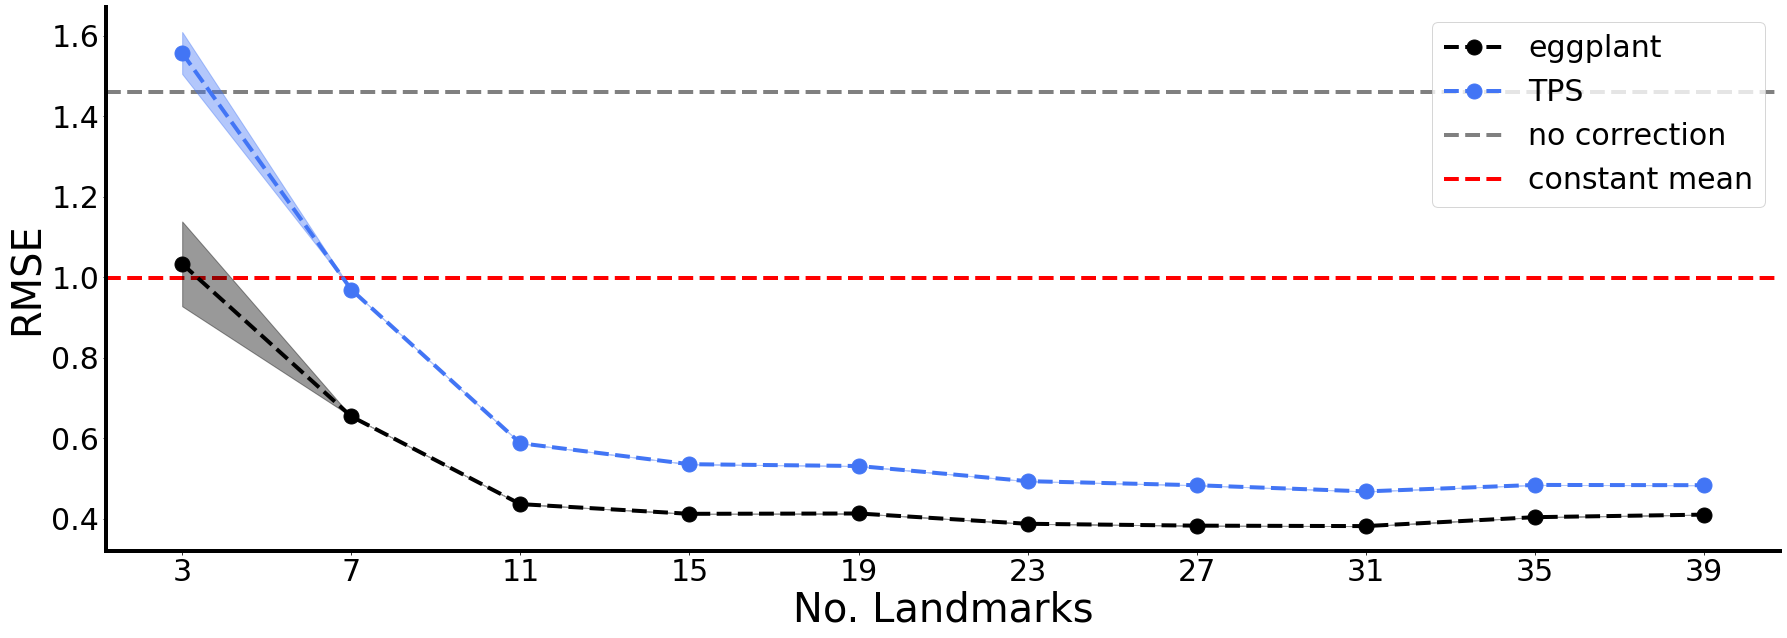

In [37]:
obs_baseline =  rmse(adata.X[:,1].flatten(),adata.X[:,0].flatten())
mean_baseline = rmse(adata.X[:,0].flatten(),np.repeat(np.mean(adata.X[:,0]),len(adata)))

fig,ax = plt.subplots(1,1,figsize = (30,10))

for df,clr,label in zip([egg_res_df,tps_res_df],["black","#4275f5"],["eggplant","TPS"]):
    mean_vals = df.values.mean(axis=1)
    std = df.values.std(axis=1)
    ax.plot(df.index.values,
             mean_vals,
             marker = "o",
             linestyle = "dashed",
             color = clr,
             label  = label,
            markersize = 15,
            linewidth = 4,
            )
    se = std / np.sqrt(egg_res_df.shape[1])
    ax.fill_between(df.index.values,
                     mean_vals - 2*se,
                     mean_vals + 2*se,
                     color = clr,
                     alpha = 0.4,
                    )

ax.axhline(y =obs_baseline,
           color = "gray",
           linewidth = 4,
           linestyle = "dashed",
           label = "no correction",zorder = -np.inf)

ax.axhline(y =mean_baseline,
           color = "red",
           linewidth = 4,
           linestyle = "dashed",
           label = "constant mean",zorder = -np.inf)

ax.set_ylabel("RMSE",fontsize  =fz,family="serif")
ax.set_xlabel("No. Landmarks",fontsize = fz,family="serif")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(4)
ax.spines["bottom"].set_linewidth(4)
ax.set_xticks(n_lmks)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.legend(fontsize=30)

if SAVE_MODE: fig.savefig(osp.join(RES_DIR,"fig-2-c.png"),bbox_inches = "tight")
plt.show()